In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from green_mood_tracker.training_data import get_raw_data_notebook
from green_mood_tracker.data_cleaning import clean

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cleme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## download and clean data

In [2]:
%%time
raw_data = get_raw_data_notebook()
raw_data.head()

c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sentiment140_final['source'] = 'sentiment140'


Wall time: 21.3 s


,id,text,polarity,source
0,1467933112,the angel is going to miss the athlete this we...,0,sts_gold
1,2323395086,It looks as though Shaq is getting traded to C...,0,sts_gold
2,1467968979,@clarianne APRIL 9TH ISN'T COMING SOON ENOUGH,0,sts_gold
3,1990283756,drinking a McDonalds coffee and not understand...,0,sts_gold
4,1988884918,So dissapointed Taylor Swift doesnt have a Twi...,0,sts_gold


In [3]:
raw_data.shape

(1633048, 4)

## Explore data

In [4]:
raw_data.source.value_counts()

sentiment140              1600000
kaggle_sentiment_train      27480
kaggle_sentiment_test        3534
sts_gold                     2034
Name: source, dtype: int64

In [5]:
raw_data.polarity.value_counts()

2    810317
0    810184
1     12547
Name: polarity, dtype: int64

## sample data

In [6]:
data_sample = raw_data.sample(n=25_000,random_state=0).reset_index()

In [7]:
%%time
data_sample_clean = clean(data_sample,'text')
data_sample_clean.head()

Wall time: 23.1 s


,index,id,text,polarity,source
0,89497,1755343696,headed yonkers back later tonight,0,sentiment140
1,212595,1974776713,tried callin past dayz tu e bueno wey,0,sentiment140
2,17473,1556303397,sister give much shit twitter im uncool,0,sentiment140
3,1526772,2177082321,thanks sun shining manchester today,2,sentiment140
4,1481406,2067068036,saw stand lookin good,2,sentiment140


## split data Train/Test

In [8]:
from sklearn.model_selection import train_test_split

X = data_sample_clean.text
y = data_sample_clean.polarity

In [9]:
# move to categorical if we're not using binary data
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [10]:
sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

## tokenize

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

tk = Tokenizer()
tk.fit_on_texts(sentence_train)
word_to_id = tk.word_index
id_to_word = {value:key for key,value in word_to_id.items()}
sentences_token_train = tk.texts_to_sequences(sentence_train)
sentences_token_test = tk.texts_to_sequences(sentence_test)

vocab_size=len(word_to_id)

## pad data

In [12]:
def generate_data(X_train,X_test):
    
    # YOUR CODE HERE
    X_train_pad = pad_sequences(X_train, dtype = 'float32',padding='post')
    X__test_pad = pad_sequences(X_test, dtype = 'float32',padding='post')
    
    return X_train_pad,X__test_pad

X_train_pad, X_test_pad = generate_data(sentences_token_train,sentences_token_test)

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

## build lstm model

In [14]:
def init_model(vocab_size):
    
    # YOUR CODE HERE
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=100, mask_zero=True))
    model.add(layers.GRU(units=13, activation='tanh')) 
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss= 'categorical_crossentropy', 
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [15]:
%%time
model_emb = init_model(vocab_size)

es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history_emb = model_emb.fit(X_train_pad, y_train,
          validation_split= 2/7,
          epochs=100, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/100
391/391 [==============================] - 22s 57ms/step - loss: 0.6911 - accuracy: 0.6365 - val_loss: 0.5822 - val_accuracy: 0.7274
Epoch 2/100
391/391 [==============================] - 15s 40ms/step - loss: 0.5098 - accuracy: 0.7774 - val_loss: 0.5671 - val_accuracy: 0.7358
Epoch 3/100
391/391 [==============================] - 16s 40ms/step - loss: 0.4402 - accuracy: 0.8222 - val_loss: 0.5909 - val_accuracy: 0.7354
Epoch 4/100
391/391 [==============================] - 15s 38ms/step - loss: 0.3844 - accuracy: 0.8513 - val_loss: 0.6345 - val_accuracy: 0.7278
Epoch 5/100
391/391 [==============================] - 15s 38ms/step - loss: 0.3356 - accuracy: 0.8724 - val_loss: 0.6603 - val_accuracy: 0.7204
Epoch 6/100
391/391 [==============================] - 15s 39ms/step - loss: 0.2940 - accuracy: 0.8901 - val_loss: 0.6911 - val_accuracy: 0.7156
Epoch 7/100
391/391 [==============================] - 16s 42ms/step - loss: 0.2577 - accuracy: 0.9077 - val_loss: 0.7454 - val_ac

235/235 [==============================] - 1s 5ms/step - loss: 0.5727 - accuracy: 0.7281
accuracy 0.7281333208084106


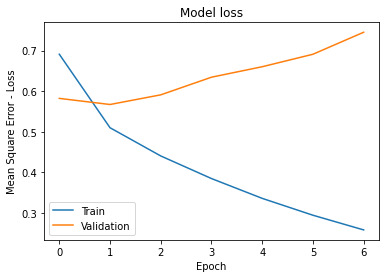

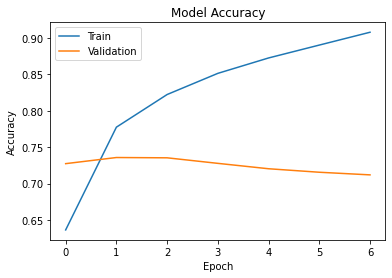

In [16]:
print('accuracy', model_emb.evaluate(X_test_pad,y_test)[1])
plot_loss(history_emb)

## build convolutional model

In [17]:
def generate_data_cnn(X_train,X_test):
    
    # YOUR CODE HERE
    X_train_pad = pad_sequences(X_train, dtype = 'float32',padding='post',maxlen=50)
    X__test_pad = pad_sequences(X_test, dtype = 'float32',padding='post',maxlen=50)
    
    return X_train_pad,X__test_pad

X_train_pad_cnn, X_test_pad_cnn = generate_data_cnn(sentences_token_train,sentences_token_test)

In [18]:
def init_model_cnn(vocab_size):
    
    model = Sequential()

    model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=100,input_length=50, mask_zero=True))
    model.add(layers.Conv1D(16,kernel_size = 5, activation='relu')) 
    model.add(layers.Flatten()) 
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss= 'categorical_crossentropy', 
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [19]:
%%time
model_cnn = init_model_cnn(vocab_size)

es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history_cnn = model_cnn.fit(X_train_pad_cnn, y_train,
          validation_split= 2/7,
          epochs=100, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/100
391/391 [==============================] - 14s 36ms/step - loss: 0.6824 - accuracy: 0.6058 - val_loss: 0.5866 - val_accuracy: 0.7220
Epoch 2/100
391/391 [==============================] - 13s 33ms/step - loss: 0.5076 - accuracy: 0.7762 - val_loss: 0.5706 - val_accuracy: 0.7374
Epoch 3/100
391/391 [==============================] - 12s 32ms/step - loss: 0.4157 - accuracy: 0.8315 - val_loss: 0.6048 - val_accuracy: 0.7278
Epoch 4/100
391/391 [==============================] - 12s 30ms/step - loss: 0.3236 - accuracy: 0.8798 - val_loss: 0.6821 - val_accuracy: 0.7036
Epoch 5/100
391/391 [==============================] - 12s 31ms/step - loss: 0.2395 - accuracy: 0.9166 - val_loss: 0.7800 - val_accuracy: 0.6924
Epoch 6/100
391/391 [==============================] - 12s 31ms/step - loss: 0.1761 - accuracy: 0.9408 - val_loss: 0.9192 - val_accuracy: 0.6744
Epoch 7/100
391/391 [==============================] - 12s 32ms/step - loss: 0.1356 - accuracy: 0.9547 - val_loss: 1.0081 - val_ac

235/235 [==============================] - 1s 3ms/step - loss: 0.5720 - accuracy: 0.7328
accuracy 0.7328000068664551


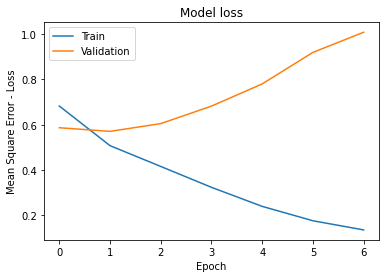

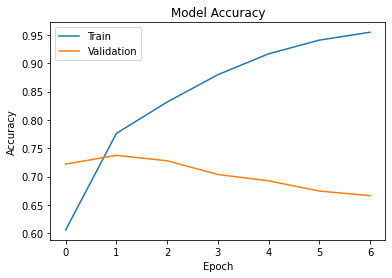

In [20]:
print('accuracy', model_cnn.evaluate(X_test_pad_cnn,y_test)[1])
plot_loss(history_cnn)

## word2vec

In [21]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=sentence_train)
vocab_size=len(word2vec.wv.vocab.keys())

In [22]:
def embed_sentence(word2vec, sentence):
    embedded=[]
    embedded_sentence = []
    for word in sentence:
         if word in word2vec.wv.vocab.keys():
             vector = word2vec.wv[word]
             embedded_sentence.append(vector)                 
    return np.array(embedded_sentence)
        

In [23]:
def embedding(word2vec, sentences):
    embedding=[]
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)  
        embedding.append(embedded_sentence)
    return embedding

In [24]:
def embedding_pipeline(word2vec, X):
    # Step #3: Sentences to list of words
    X = embedding(word2vec, X) 
    # Step #4: Pad the inputs
    X = pad_sequences(X, dtype='float32', padding='post') 
    return X

In [25]:
X_train_pad_w2v = embedding_pipeline(word2vec, sentence_train.values)
X__test_pad_w2v = embedding_pipeline(word2vec, sentence_test.values)

In [26]:
def init_model_w2v(vocab_size):

    model = Sequential()

    model.add(layers.Masking(mask_value=0.))
    model.add(layers.GRU(units=13, activation='tanh')) 
    model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dropout(.2))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss= 'categorical_crossentropy', 
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

### Train word2vec on internal data

In [ ]:
%%time
model_w2v = init_model_w2v(vocab_size)

es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history_w2v = model_w2v.fit(X_train_pad_w2v, y_train,
          validation_split= 2/7,
          epochs=50, 
          batch_size=16, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/50
535/782 [===================>..........] - ETA: 35s - loss: 0.7463 - accuracy: 0.5032

In [ ]:
print('accuracy', model_cnn.evaluate(X_test_pad_w2v,y_test)[1])
plot_loss(history_w2v)

In [ ]:
model_w2v.evaluate(X__test_pad_word2v,y_test)

### Train word2vec on Google news

In [ ]:
%%time

import gensim.downloader as api
word2vec_gnews = api.load("word2vec-google-news-300")

In [ ]:
X_train_pad_w2v_gnews = embedding_pipeline(word2vec_gnews, sentence_train[:10000].values)
X__test_pad_w2v_gnews = embedding_pipeline(word2vec_gnews, sentence_test[:10000].values)

In [ ]:
%%time
model_w2v_gnews = init_model_w2v(vocab_size)

es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history_w2v_gnews = model_w2v.fit(X_train_pad_w2v_gnews, y_train,
          validation_split= 2/7,
          epochs=50, 
          batch_size=16, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

In [ ]:
print('accuracy', model_cnn.evaluate(X_test_pad_w2v_gnews,y_test)[1])
plot_loss(history_w2v_gnews)

## Evaluate

In [ ]:
print('w2v_internal accuracy:',model_w2v.evaluate(X_test_pad_w2v,y_test))

In [ ]:
print('w2v_gnews accuracy:',model_w2v.evaluate(X_test_pad_w2v_gnews,y_test))

In [ ]:
print('embeddings+LSTM accuracy:'model_emb.evaluate(X_test_pad,y_test))

In [ ]:
print('cnn accuracy:',model_cnn.evaluate(X_test_pad_cnn,y_test))

### Predict on London

In [ ]:
import nest_asyncio
import sys
from green_mood_tracker.twint_class import TWINT
nest_asyncio.apply()

In [ ]:
import sys
sys.path.insert(0, '../green_mood_tracker/')

In [ ]:
kwargs = dict(
    keywords=['nuclear', 'green'],
    cities=['London', 'paris'],
    since = '2020-11-10 12:00:00',
    limit=200,
    file_path='../green_mood_tracker/data/london_nuclear.csv'
)

# t = TWINT(**kwargs)

# df_city = t.city_csv()

In [ ]:
! ls ../green_mood_tracker/data/

In [ ]:
csv = pd.read_csv('../green_mood_tracker/data/london_nuclear.csv')